In [1]:
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split

def load_images(image_folder):
    images = []
    for image_file in sorted(os.listdir(image_folder)):
        if image_file.endswith('.jpg') or image_file.endswith('.jpeg') or image_file.endswith('.png'):
            image_path = os.path.join(image_folder, image_file)
            image = Image.open(image_path).convert('L')
            image = image.resize((256, 256))  # Resize images to a fixed size
            image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
            images.append(image)
    return np.array(images)

def create_dataset(new_downloaded_folder, new_cleaned_folder, glyph_folder):
    downloaded_images = load_images(new_downloaded_folder)
    cleaned_images = load_images(new_cleaned_folder)
    glyph_images = load_images(glyph_folder)
    
    X_combined = np.stack((downloaded_images, glyph_images), axis=-1)
    
    X_train, X_test, y_train, y_test = train_test_split(X_combined, cleaned_images, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Directories
new_downloaded_folder = './new_downloaded_images'
new_cleaned_folder = './new_cleaned_images'
glyph_folder = './glyph_images'

# Create dataset
X_train, X_val, X_test, y_train, y_val, y_test = create_dataset(new_downloaded_folder, new_cleaned_folder, glyph_folder)

# Reshape data to add channel dimension for target
y_train = np.expand_dims(y_train, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

In [ ]:
#condition glyph image generation
#use only once

'''import os
from PIL import Image, ImageDraw, ImageFont

def create_glyph_image(glyph, font_path, output_path, image_size=(256, 256), font_size=80):
    # Create a blank image with white background
    image = Image.new('L', image_size, color=255)
    draw = ImageDraw.Draw(image)
    
    # Load the font
    font = ImageFont.truetype(font_path, font_size)
    
    # Calculate the size and position to center the glyph
    text_bbox = draw.textbbox((0, 0), glyph, font=font)
    text_width = text_bbox[2] - text_bbox[0]
    text_height = text_bbox[3] - text_bbox[1]
    
    # Adjust the position to center the glyph
    position = ((image_size[0] - text_width) // 2, (image_size[1] - text_height) // 2 - text_bbox[1])
    
    # Draw the glyph on the image
    draw.text(position, glyph, fill=0, font=font)  # Draw the glyph in black
    
    # Save the image
    image.save(output_path)

def generate_glyph_images(dirty_images_folder, font_path, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for image_file in sorted(os.listdir(dirty_images_folder)):
        if image_file.endswith('.jpg') or image_file.endswith('.jpeg') or image_file.endswith('.png'):
            glyph = image_file.split('_')[0]  # Extract the glyph from the filename
            output_path = os.path.join(output_folder, image_file.replace('.jpg', '_glyph.png').replace('.jpeg', '_glyph.png').replace('.png', '_glyph.png'))
            create_glyph_image(glyph, font_path, output_path)

if __name__ == "__main__":
    dirty_images_folder = './new_downloaded_images'
    font_path = './mine.ttf'
    output_folder = './glyph_images'
    
    generate_glyph_images(dirty_images_folder, font_path, output_folder)'''

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError

def combined_loss(y_true, y_pred):
    bce = BinaryCrossentropy()(y_true, y_pred)
    mse = MeanSquaredError()(y_true, y_pred)
    return bce + 0.01 * mse

def unet_model(input_size=(256, 256, 2)):
    inputs = layers.Input(input_size)
    
    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = layers.Conv2D(512, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv5))
    merge6 = layers.concatenate([conv4, up6], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2D(256, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv6))
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv2D(128, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv7))
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = layers.Conv2D(64, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv8))
    merge9 = layers.concatenate([conv1, up9], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = layers.Conv2D(2, 3, activation='relu', padding='same')(conv9)
    conv9 = layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    model = models.Model(inputs, conv9)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss=combined_loss, metrics=['accuracy'])
    
    return model
model = unet_model()

In [8]:
# Initialize and train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=1, validation_data=(X_val, y_val))

Epoch 1/50
2347/2347 ━━━━━━━━━━━━━━━━━━━━ 52s 18ms/step - accuracy: 0.9701 - loss: 0.0937 - val_accuracy: 0.9829 - val_loss: 0.0323
Epoch 2/50
2347/2347 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.9812 - loss: 0.0335 - val_accuracy: 0.9813 - val_loss: 0.0301
Epoch 3/50
2347/2347 ━━━━━━━━━━━━━━━━━━━━ 42s 18ms/step - accuracy: 0.9816 - loss: 0.0307 - val_accuracy: 0.9841 - val_loss: 0.0252
Epoch 4/50
2347/2347 ━━━━━━━━━━━━━━━━━━━━ 42s 18ms/step - accuracy: 0.9827 - loss: 0.0271 - val_accuracy: 0.9859 - val_loss: 0.0197
Epoch 5/50
2347/2347 ━━━━━━━━━━━━━━━━━━━━ 42s 18ms/step - accuracy: 0.9845 - loss: 0.0225 - val_accuracy: 0.9854 - val_loss: 0.0235
Epoch 6/50
2347/2347 ━━━━━━━━━━━━━━━━━━━━ 42s 18ms/step - accuracy: 0.9848 - loss: 0.0211 - val_accuracy: 0.9852 - val_loss: 0.0203
Epoch 7/50
2347/2347 ━━━━━━━━━━━━━━━━━━━━ 43s 18ms/step - accuracy: 0.9856 - loss: 0.0197 - val_accuracy: 0.9872 - val_loss: 0.0177
Epoch 8/50
2347/2347 ━━━━━━━━━━━━━━━━━━━━ 42s 18ms/step - accuracy: 0.9860 -

KeyboardInterrupt: 

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step


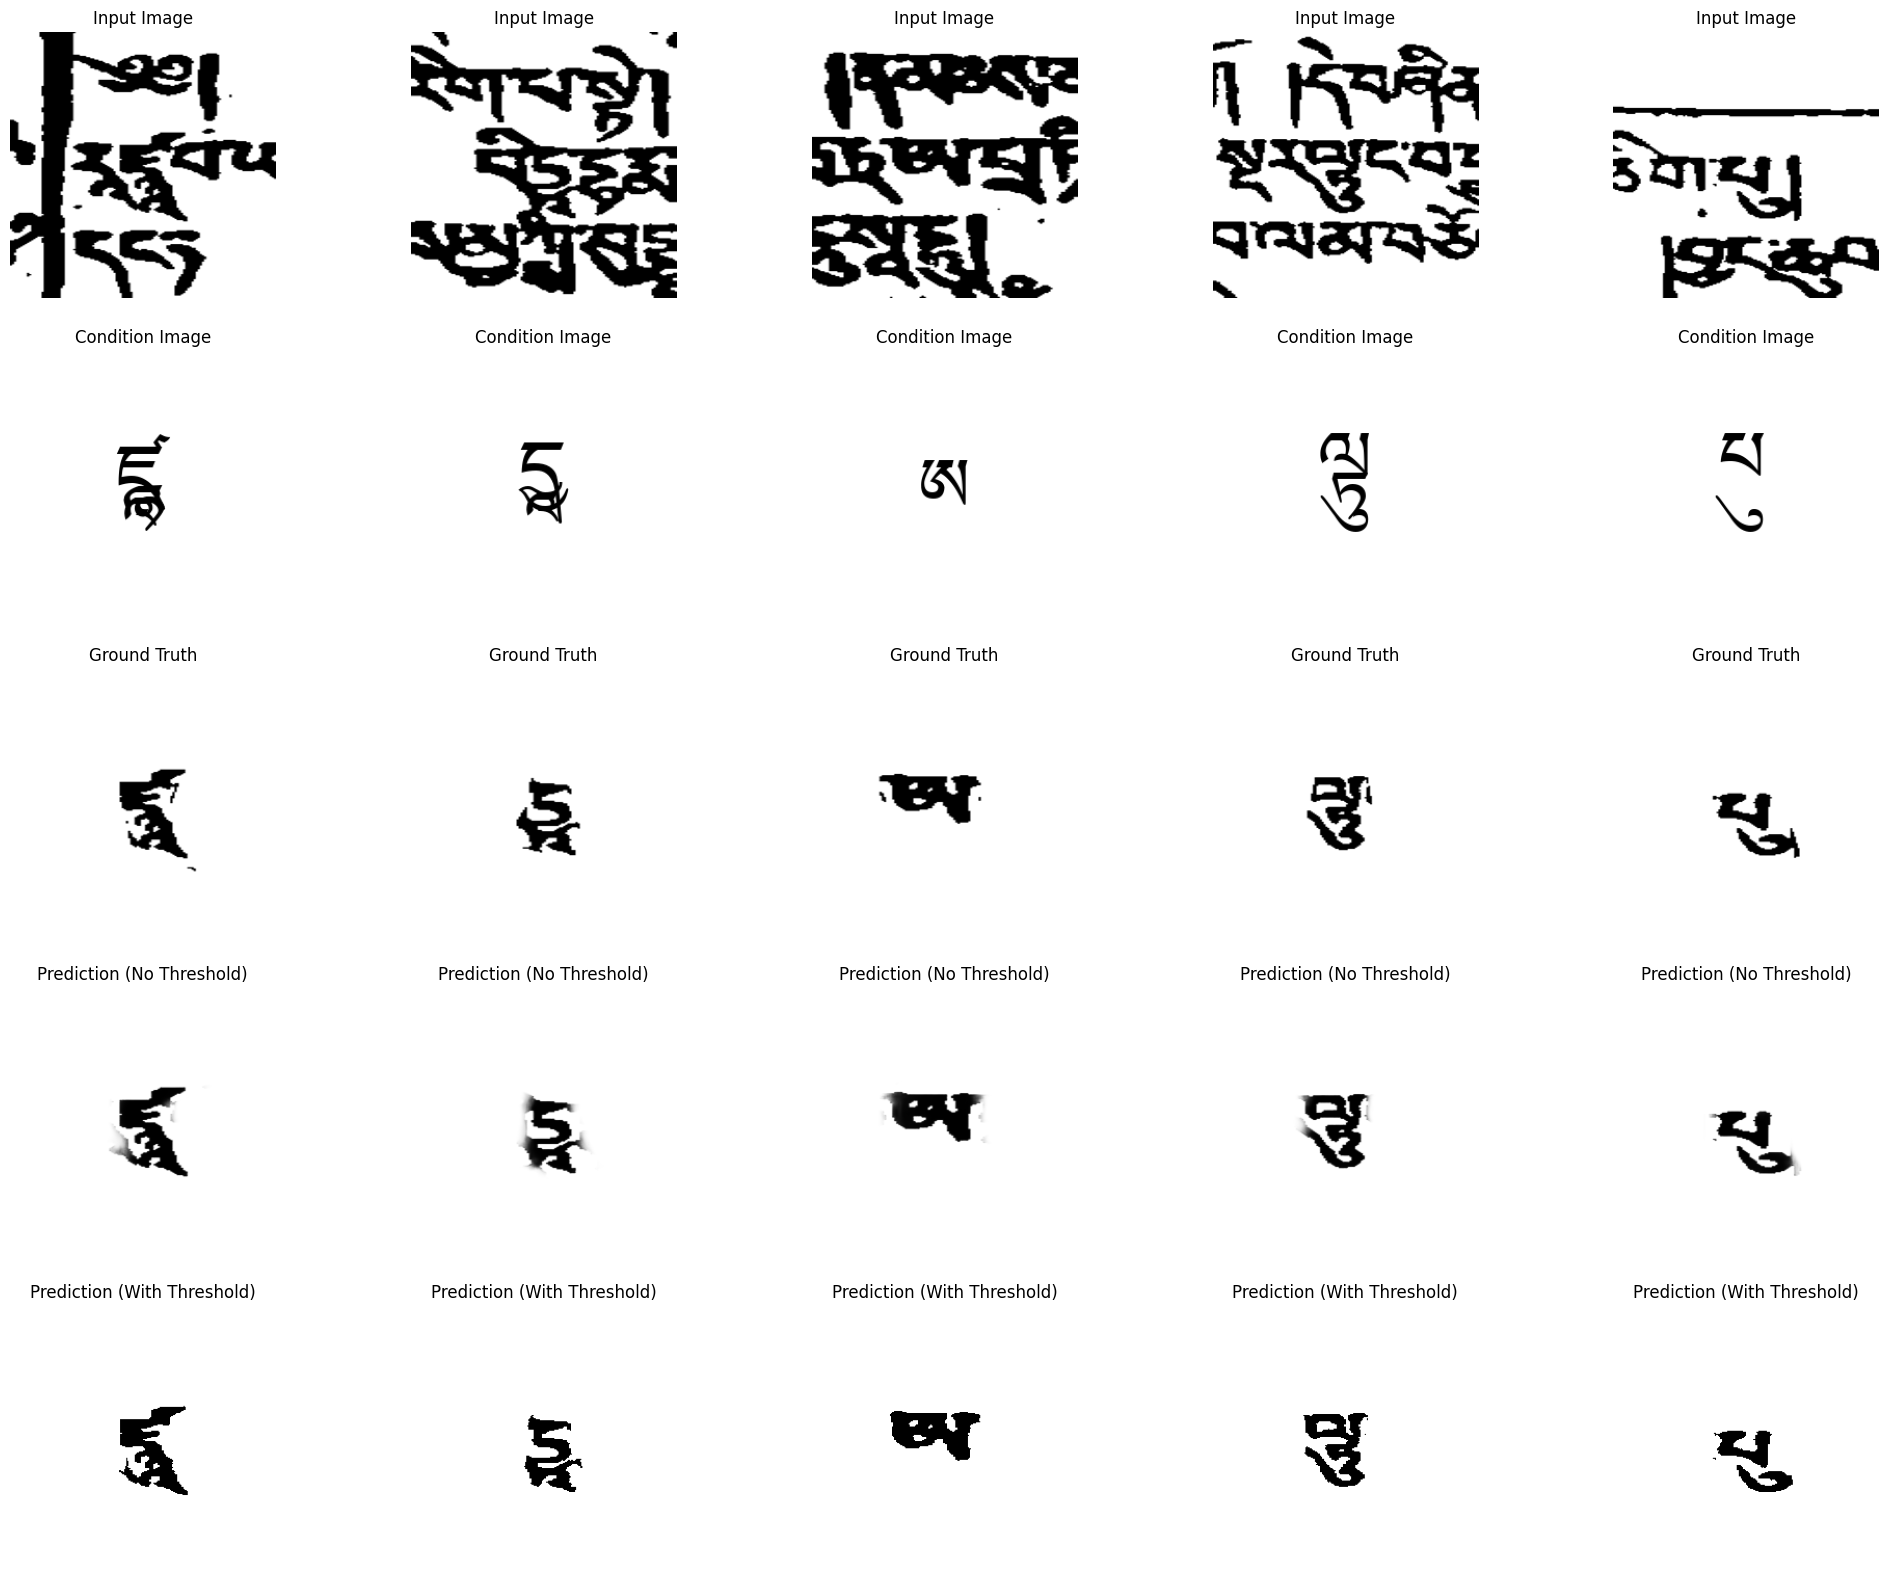

In [25]:
import matplotlib.pyplot as plt

def apply_threshold(image, threshold=0.5):
    return (image > threshold).astype(np.float32)

def display_sample_predictions(model, X_test, y_test):
    predictions = model.predict(X_test)
    n_samples = 5
    plt.figure(figsize=(25, 20))
    for i in range(n_samples):
        idx = random.randint(0, len(X_test) - 1)
        
        plt.subplot(5, n_samples, i + 1)
        plt.title("Input Image")
        plt.imshow(X_test[idx, :, :, 0], cmap='gray')  # Show the dirty image part
        plt.axis('off')
        
        plt.subplot(5, n_samples, i + n_samples + 1)
        plt.title("Condition Image")
        plt.imshow(X_test[idx, :, :, 1], cmap='gray')  # Show the glyph image part
        plt.axis('off')

        plt.subplot(5, n_samples, i + 2 * n_samples + 1)
        plt.title("Ground Truth")
        plt.imshow(y_test[idx].squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(5, n_samples, i + 3 * n_samples + 1)
        plt.title("Prediction (No Threshold)")
        plt.imshow(predictions[idx].squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(5, n_samples, i + 4 * n_samples + 1)
        plt.title("Prediction (With Threshold)")
        plt.imshow(apply_threshold(predictions[idx]).squeeze(), cmap='gray')
        plt.axis('off')

    plt.show()

# Display sample predictions
display_sample_predictions(model, X_test, y_test)